# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [1]:
# Import your libraries:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import DBSCAN

/home/flori/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Challenge 1 - Import and Describe the Dataset

In this lab, we will use a dataset containing information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

The origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

In [2]:
# loading the data:
customers = pd.read_csv('../Wholesale customers data.csv')

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [3]:
# Your code here:
display(customers.shape) # analizo los records y features que contiene el dataset
display(customers.dtypes) # ver si alguna feature no es numérica
display(customers.isnull().sum()) # analizo nulos
customers.head()

(440, 8)

Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
# analizo el número de variables únicas en las dos columnas que parecen que eran categóricas
display(customers.Channel.unique())
display(customers.Region.unique())

array([2, 1])

array([3, 1, 2])

In [5]:
# miro el numero de valores de cada tipo en Channel y Region. Mientras que en Channel están más proporcionadas, 
# en region están desbalanceadas. Simplemente, hay más registros en la región 3,es decir, más consumidores, 
# pero esto puede afectar al clustering.
display(customers.Channel.value_counts())
customers.Region.value_counts()

1    298
2    142
Name: Channel, dtype: int64

3    316
1     77
2     47
Name: Region, dtype: int64

In [6]:
df = customers.drop(columns=["Region","Channel"])
df.corr()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Fresh,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicassen,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


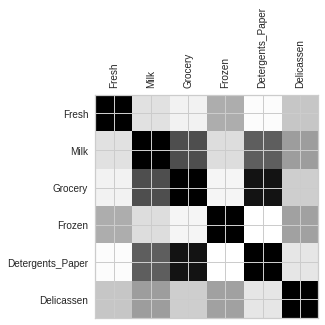

In [7]:
plt.matshow(df.corr())
plt.xticks(range(df.shape[1]), df.columns, rotation=90)
plt.yticks(range(df.shape[1]), df.columns)
plt.show()

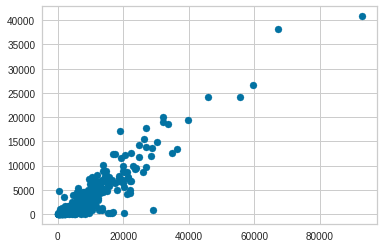

In [8]:
#No se puede ver bien la correlación por los outliers
plt.scatter(df["Grocery"],df["Detergents_Paper"])

In [9]:
columnas = list(df.columns)
columnas

['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

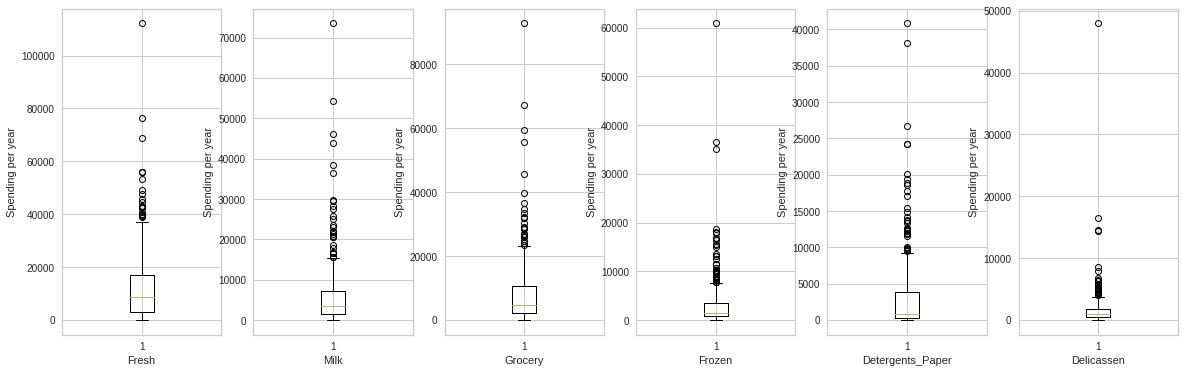

In [10]:
# Boxplots para ver los outliers. Hay outliers por encima del 95% del total de las muestras en todas las features
plt.figure(figsize=(20,6))
plt.subplots
for i in range(1,7):
    plt.subplot(1,6,i)
    plt.boxplot(df[columnas[i-1]])
    plt.xlabel(columnas[i-1])
    plt.ylabel("Spending per year")
plt.show()

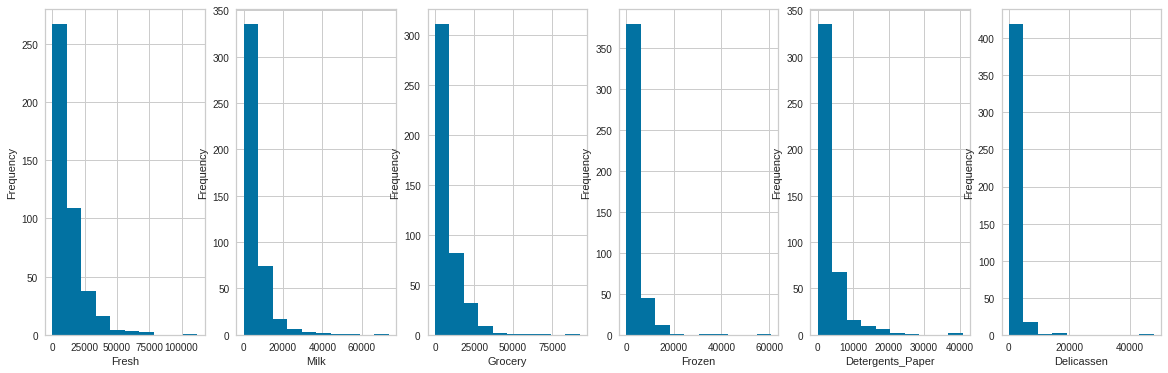

In [11]:
# Histogramas para ver las distribuciones. Las distribuciones están sesgadas a la derecha, no son distribuciones normales, sino  
# exponenciales. La media es mayor que la mediana y la mediana está cerca del primer cuartil, como ya se aprecia en los boxplots
plt.figure(figsize=(20,6))
plt.subplots
for i in range(1,7):
    plt.subplot(1,6,i)
    plt.hist(df[columnas[i-1]])
    plt.xlabel(columnas[i-1])
    plt.ylabel("Frequency")
plt.show()

In [12]:
df.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Your observations here
1) El dataset contiene 440 variables o filas y 8 features. Todas las columnas son de tipo int, es decir, numéricas. De esas 8 features, 6 corresponden a tipo de producto (fresh, milk, grocery...) y las otras 2 corresponden a variables categóricas que han pasado a ser numéricas: la región y el canal. El canal tiene 2 tipos de datos únicos (1,2) y la región 3 (1,2,3). La feature region está muy desbalanceada hacia 3. Estas dos columnas, channel y region no son features para el clustering, ya que no aporta datos sobre el gasto de los clientes y además están desbalanceadas. Así que habría que eliminarlas.

2) No hay missing values. 

3) Los datos entre columnas son muy diferentes. Por ejemplo, la media de fresh es una unidad de medida mayor que la de Delicassen. Por lo que habría que estandarizar los datos. Además los datos no siguen una distribución normal, quizás habría que operar con ellos para conseguir una distribución normal.

4) Según el mapa de correlación, las features Detergents_Paper y Grocery tienen una alta correlación directa (0.92). Es posible que estos datos sean redundantes y que se pueda eliminar una de las dos.

5) Hay outliers en todas las features cuyo valor se encuentra por encima del conjunto del 95% de los datos. Habría que eliminarlos para que no afecten al clustering.

# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [13]:
# Your code here
# 1) Me quedo con el dataframe df, en el que ya había eliminado las columnas Channel y Region
# 2) Elimino outliers en cada columna:
# Nota: he probado y creo que eliminar los que están por encima del quantile 90 es lo apropiado (por encima de 95 siguen quedando muchos)
def removeOutliers(x):
    return x[x.between(x.quantile(0), x.quantile(.90))]

df_sin_outliers = (df.apply(removeOutliers)).reset_index().set_index("index")
df_sin_outliers.head()
#customers[columnas] = customers[columnas].apply(removeOutliers)
#customers.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
index,,,,,,
0,12669.0,9656.0,7561.0,214.0,2674.0,1338.0
1,7057.0,9810.0,9568.0,1762.0,3293.0,1776.0
2,6353.0,8808.0,7684.0,2405.0,3516.0,NaN
3,13265.0,1196.0,4221.0,6404.0,507.0,1788.0
4,22615.0,5410.0,7198.0,3915.0,1777.0,NaN


In [14]:
# Se han generado valores nulos
print(df_sin_outliers.isnull().sum())
# voy a eliminar esa filas
df_sin_outliers.dropna(axis=0,how="any",inplace=True)
df_sin_outliers.isnull().sum()

Fresh               43
Milk                43
Grocery             43
Frozen              43
Detergents_Paper    43
Delicassen          43
dtype: int64


Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

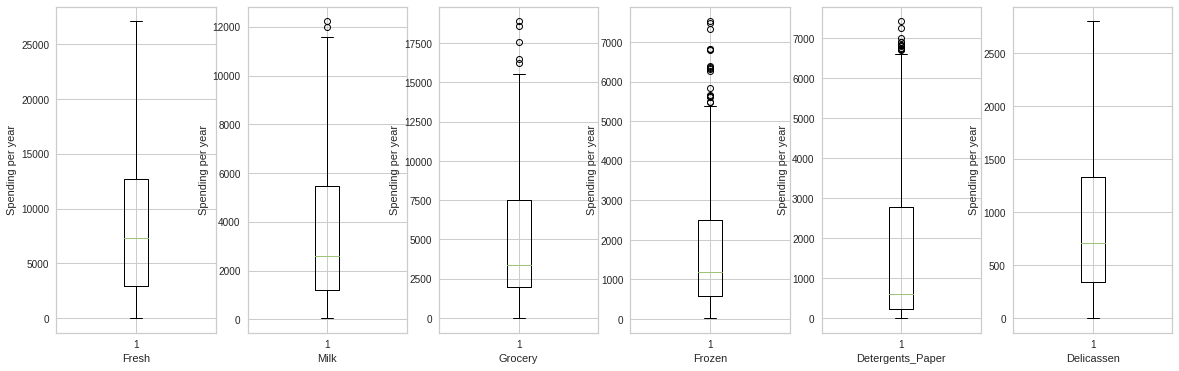

In [15]:
# ahora hay menos outliers que puedan distorsionar el clustering
plt.figure(figsize=(20,6))
plt.subplots
for i in range(1,7):
    plt.subplot(1,6,i)
    plt.boxplot(df_sin_outliers[columnas[i-1]])
    plt.xlabel(columnas[i-1])
    plt.ylabel("Spending per year")
plt.show()

In [16]:
df_sin_outliers.shape

(287, 6)

In [57]:
# Your comment here
#Quizás debería eliminar o la columna Grocery o Detergents_Paper, pero voy a seguir con ambas
# transformar las distribuciones a normales?

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [18]:
# Your import here:

from sklearn.preprocessing import StandardScaler

# Your code here:
scaler = StandardScaler().fit(df_sin_outliers)
customers_scale = scaler.transform(df_sin_outliers)

In [19]:
#Conseguimos que los datos de las diferentes columnas estén en un rango similar
customers_scale

array([[ 0.60180582,  2.01858165,  0.60577232, -0.94849399,  0.50662986,
         0.6418779 ],
       [-0.2328248 ,  2.07038701,  1.08760844, -0.02635997,  0.81540628,
         1.28079264],
       [ 0.69044443, -0.82734909, -0.19608751,  2.73885071, -0.57433705,
         1.29829716],
       ...,
       [ 1.20591659,  0.08967304,  0.709726  , -0.66613513,  0.35548405,
        -0.08747682],
       [ 0.24799501, -0.56327632, -0.67360224, -0.45764229, -0.74344078,
         1.78988224],
       [-0.86786984, -0.65847707, -0.60686061, -1.03725237, -0.58930198,
        -1.23402246]])

# Challenge 3 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

/home/flori/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fed5968b110>,
                 k=None, locate_elbow=True, metric='silhouette', model=None,
                 timings=False)

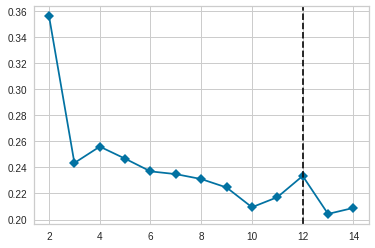

In [20]:
# Miro primero KElbowVisualizer con la metrica de silhouette para decidir en qué entorno de numero de clusterings estaría bien 
# situar la k. He probrado con las tres metricas (silhouette,distorsion y calinski_harabasz) y creo que entre 3 y 6 clusters estaría bien

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,15), metric="silhouette", timings=False)

visualizer.fit(customers_scale) 

In [21]:
# Your code here:
kmeans = KMeans(n_clusters=5)
kmeans.fit(customers_scale)
df_sin_outliers["labels"] = kmeans.labels_
df_sin_outliers.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels
index,,,,,,,
0,12669.0,9656.0,7561.0,214.0,2674.0,1338.0,0
1,7057.0,9810.0,9568.0,1762.0,3293.0,1776.0,0
3,13265.0,1196.0,4221.0,6404.0,507.0,1788.0,2
5,9413.0,8259.0,5126.0,666.0,1795.0,1451.0,3
6,12126.0,3199.0,6975.0,480.0,3140.0,545.0,1


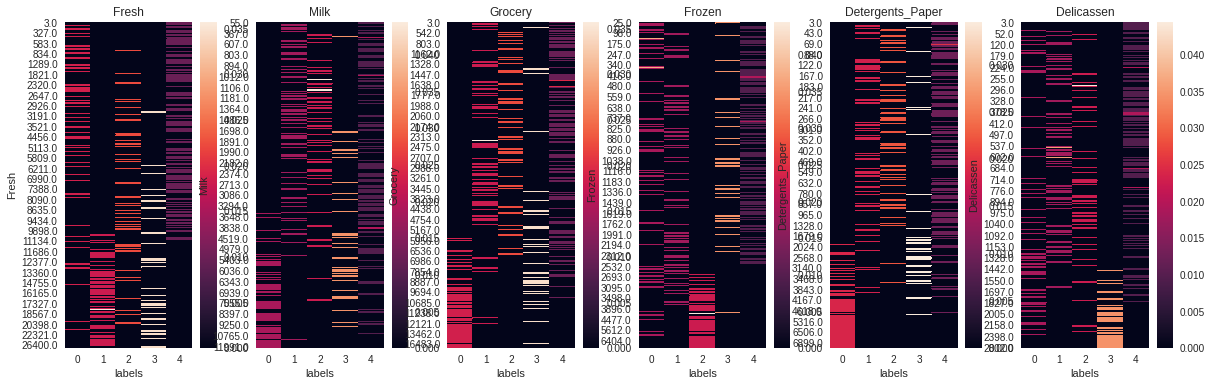

In [22]:
plt.figure(figsize=(20,6))
plt.subplots
i=0
for e in columnas:
    i+=1
    plt.subplot(1,6,i)
    sns.heatmap(pd.crosstab(df_sin_outliers[e],[df_sin_outliers.labels], normalize="columns"))
    plt.title(e)

Con estos heatmaps podemos ver que:
- grupo 0 gasta más al año en Detergents_Paper y Grocery (dos variables muy relacionadas)
- grupo 1 gasta similar en todos los productos
- el grupo 2 en Fresh
- grupo 3 en Frozen
- grupo 4 Delicassen

Count the values in `labels`.

In [23]:
# Your code here
# Por ahora voy a dejar 5 clusters
df_sin_outliers["labels"].value_counts()

4    103
1     56
0     54
2     45
3     29
Name: labels, dtype: int64

Aunque el numero no está completamente balanceado, todos tienen más del 10% de los clientes

# Challenge 4 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [24]:
# Your code here
clustering = DBSCAN(eps=0.5)
clustering.fit(customers_scale)
df_sin_outliers['labels_DBSCAN'] = clustering.labels_

Count the values in `labels_DBSCAN`.

In [25]:
# Your code here
df_sin_outliers["labels_DBSCAN"].value_counts()

-1    259
 0     20
 1      8
Name: labels_DBSCAN, dtype: int64

# Challenge 5 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

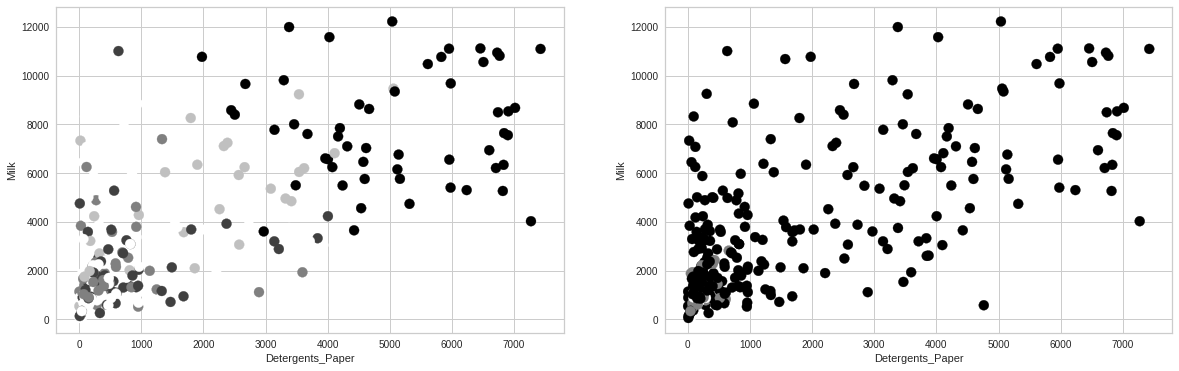

In [39]:
# Your code here:
plt.figure(figsize=(20,6))
plt.subplots
plt.subplot(1,2,1)
plt.scatter(df_sin_outliers["Detergents_Paper"],df_sin_outliers["Milk"],s=100,c=df_sin_outliers["labels"],cmap='gray')
plt.xlabel("Detergents_Paper")
plt.ylabel("Milk")

plt.subplot(1,2,2)
plt.scatter(df_sin_outliers["Detergents_Paper"],df_sin_outliers["Milk"],s=100,c=df_sin_outliers["labels_DBSCAN"],cmap='gray')
plt.xlabel("Detergents_Paper")
plt.ylabel("Milk")

plt.show()

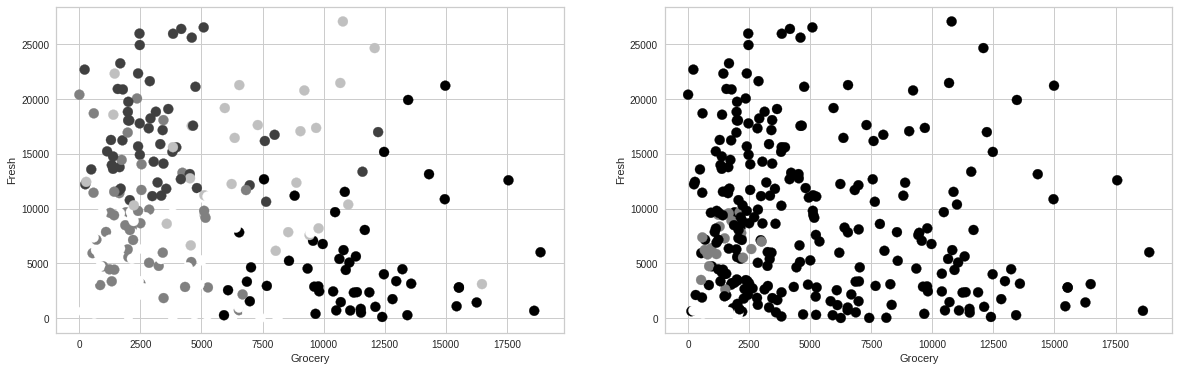

In [40]:
plt.figure(figsize=(20,6))
plt.subplots
plt.subplot(1,2,1)
plt.scatter(df_sin_outliers["Grocery"],df_sin_outliers["Fresh"],s=100,c=df_sin_outliers["labels"],cmap='gray')
plt.xlabel("Grocery")
plt.ylabel("Fresh")

plt.subplot(1,2,2)
plt.scatter(df_sin_outliers["Grocery"],df_sin_outliers["Fresh"],s=100,c=df_sin_outliers["labels_DBSCAN"],cmap='gray')
plt.xlabel("Grocery")
plt.ylabel("Fresh")

plt.show()

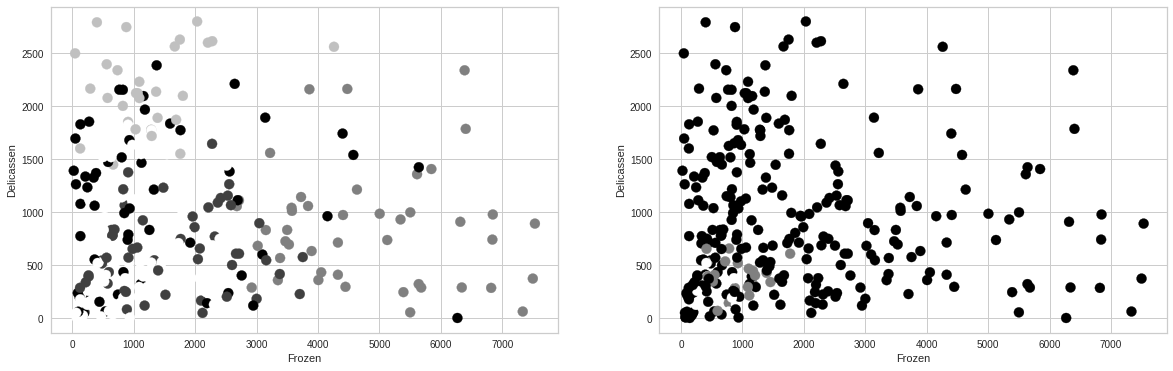

In [38]:
plt.figure(figsize=(20,6))
plt.subplots
plt.subplot(1,2,1)
plt.scatter(df_sin_outliers["Frozen"],df_sin_outliers["Delicassen"],s=100,c=df_sin_outliers["labels"],cmap='gray')
plt.xlabel("Frozen")
plt.ylabel("Delicassen")

plt.subplot(1,2,2)
plt.scatter(df_sin_outliers["Frozen"],df_sin_outliers["Delicassen"],s=100,c=df_sin_outliers["labels_DBSCAN"],cmap='gray')
plt.xlabel("Frozen")
plt.ylabel("Delicassen")

plt.show()

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [41]:
# Your code here:
df_sin_outliers_groupLabels = df_sin_outliers.groupby(["labels"]).agg("mean")
df_sin_outliers_groupLabelsDBSCAN =df_sin_outliers.groupby(["labels_DBSCAN"]).agg("mean")
display(df_sin_outliers_groupLabels)
df_sin_outliers_groupLabelsDBSCAN

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels_DBSCAN
labels,,,,,,,
0,5076.962963,7851.018519,11461.722222,1422.592593,5052.111111,1096.907407,-1.000000
1,16936.660714,1986.250000,3360.928571,1572.000000,731.464286,632.875000,-1.000000
2,8634.355556,2064.200000,2574.555556,4778.000000,559.733333,852.822222,-1.000000
3,14348.586207,4940.344828,6994.241379,1245.793103,1935.103448,2176.862069,-1.000000
4,4343.621359,2696.747573,3106.854369,994.213592,785.135922,597.446602,-0.650485


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels
labels_DBSCAN,,,,,,,
-1,9008.602317,3920.96139,5416.227799,1911.861004,1812.046332,955.80695,2.057915
0,6827.850000,1300.70000,1594.700000,925.650000,264.500000,404.55000,4.000000
1,609.000000,945.75000,1392.750000,588.625000,167.625000,259.00000,4.000000


Which algorithm appears to perform better?

In [56]:
# Your observations here
# Con K-means los grupos parecen estar mejor separados. Las medias son más diferentes

# Bonus Challenge 2 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

In [42]:
# Your code here
# En el ejercicio de KMeans había puesto k=5, así que ahora voy a probar con los 8 que vienen por defecto
kmeans = KMeans()
kmeans.fit(customers_scale)
df_sin_outliers["labels_k8"] = kmeans.labels_
df_sin_outliers.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels,labels_DBSCAN,labels_k8
index,,,,,,,,,
0,12669.0,9656.0,7561.0,214.0,2674.0,1338.0,0,-1,1
1,7057.0,9810.0,9568.0,1762.0,3293.0,1776.0,0,-1,1
3,13265.0,1196.0,4221.0,6404.0,507.0,1788.0,2,-1,5
5,9413.0,8259.0,5126.0,666.0,1795.0,1451.0,3,-1,1
6,12126.0,3199.0,6975.0,480.0,3140.0,545.0,1,-1,7


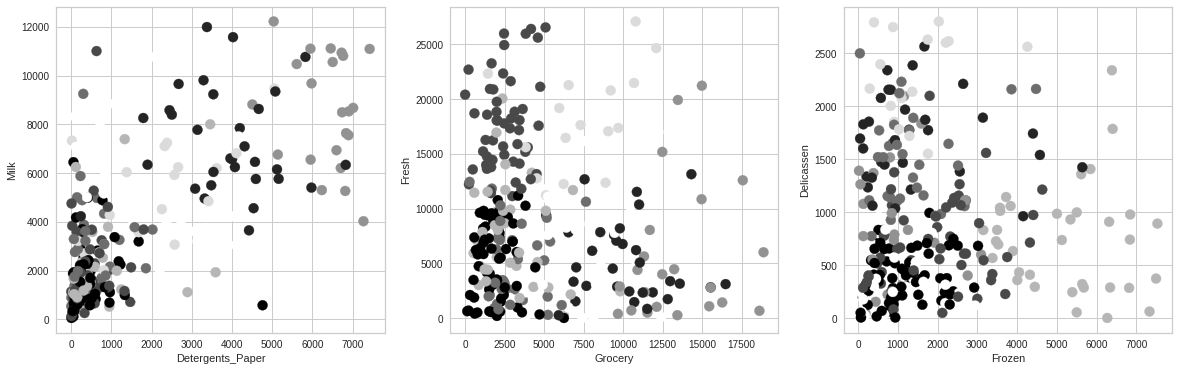

In [45]:
# Your comment here
plt.figure(figsize=(20,6))
plt.subplots
plt.subplot(1,3,1)
plt.scatter(df_sin_outliers["Detergents_Paper"],df_sin_outliers["Milk"],s=100,c=df_sin_outliers["labels_k8"],cmap='gray')
plt.xlabel("Detergents_Paper")
plt.ylabel("Milk")
plt.subplot(1,3,2)
plt.scatter(df_sin_outliers["Grocery"],df_sin_outliers["Fresh"],s=100,c=df_sin_outliers["labels_k8"],cmap='gray')
plt.xlabel("Grocery")
plt.ylabel("Fresh")
plt.subplot(1,3,3)
plt.scatter(df_sin_outliers["Frozen"],df_sin_outliers["Delicassen"],s=100,c=df_sin_outliers["labels_k8"],cmap='gray')
plt.xlabel("Frozen")
plt.ylabel("Delicassen")
plt.show()

In [46]:
# Voy a probar 4
kmeans = KMeans(n_clusters=4)
kmeans.fit(customers_scale)
df_sin_outliers["labels_k4"] = kmeans.labels_
df_sin_outliers.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels,labels_DBSCAN,labels_k8,labels_k4
index,,,,,,,,,,
0,12669.0,9656.0,7561.0,214.0,2674.0,1338.0,0,-1,1,0
1,7057.0,9810.0,9568.0,1762.0,3293.0,1776.0,0,-1,1,0
3,13265.0,1196.0,4221.0,6404.0,507.0,1788.0,2,-1,5,3
5,9413.0,8259.0,5126.0,666.0,1795.0,1451.0,3,-1,1,0
6,12126.0,3199.0,6975.0,480.0,3140.0,545.0,1,-1,7,1


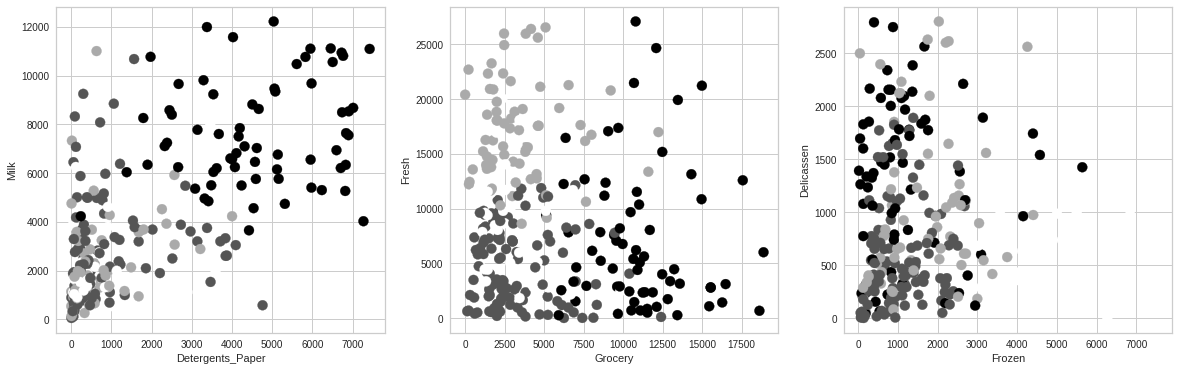

In [47]:
plt.figure(figsize=(20,6))
plt.subplots
plt.subplot(1,3,1)
plt.scatter(df_sin_outliers["Detergents_Paper"],df_sin_outliers["Milk"],s=100,c=df_sin_outliers["labels_k4"],cmap='gray')
plt.xlabel("Detergents_Paper")
plt.ylabel("Milk")
plt.subplot(1,3,2)
plt.scatter(df_sin_outliers["Grocery"],df_sin_outliers["Fresh"],s=100,c=df_sin_outliers["labels_k4"],cmap='gray')
plt.xlabel("Grocery")
plt.ylabel("Fresh")
plt.subplot(1,3,3)
plt.scatter(df_sin_outliers["Frozen"],df_sin_outliers["Delicassen"],s=100,c=df_sin_outliers["labels_k4"],cmap='gray')
plt.xlabel("Frozen")
plt.ylabel("Delicassen")
plt.show()

In [58]:
# Creo que el de k = 5 (5 clusters, probado en el challenge anterior) separa mejor los grupos

# Bonus Challenge 3 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

In [48]:
# Your code here
clustering = DBSCAN(eps=1, min_samples=5)
clustering.fit(customers_scale)
df_sin_outliers['labels_DBSCAN_eps1'] = clustering.labels_
df_sin_outliers['labels_DBSCAN_eps1'].value_counts()

 1    153
-1    116
 2     11
 0      7
Name: labels_DBSCAN_eps1, dtype: int64

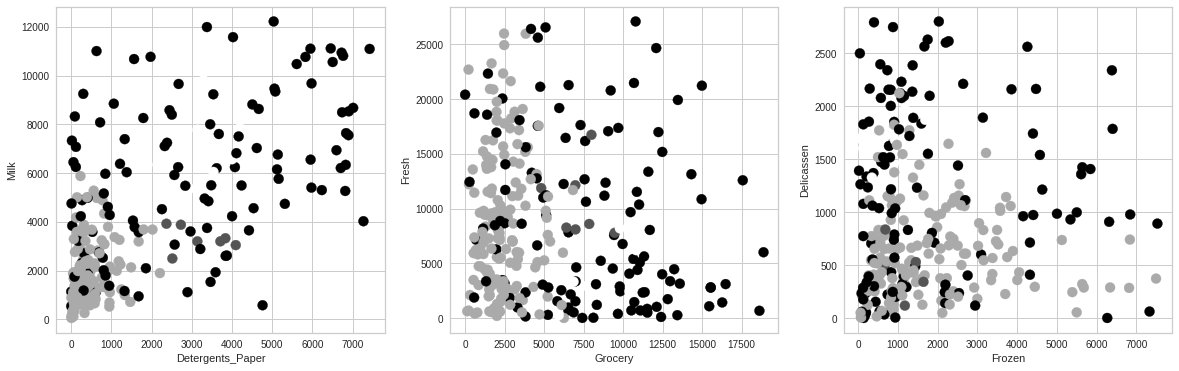

In [49]:
plt.figure(figsize=(20,6))
plt.subplots
plt.subplot(1,3,1)
plt.scatter(df_sin_outliers["Detergents_Paper"],df_sin_outliers["Milk"],s=100,c=df_sin_outliers["labels_DBSCAN_eps1"],cmap='gray')
plt.xlabel("Detergents_Paper")
plt.ylabel("Milk")
plt.subplot(1,3,2)
plt.scatter(df_sin_outliers["Grocery"],df_sin_outliers["Fresh"],s=100,c=df_sin_outliers["labels_DBSCAN_eps1"],cmap='gray')
plt.xlabel("Grocery")
plt.ylabel("Fresh")
plt.subplot(1,3,3)
plt.scatter(df_sin_outliers["Frozen"],df_sin_outliers["Delicassen"],s=100,c=df_sin_outliers["labels_DBSCAN_eps1"],cmap='gray')
plt.xlabel("Frozen")
plt.ylabel("Delicassen")
plt.show()

In [50]:
clustering = DBSCAN(eps=2, min_samples=5)
clustering.fit(customers_scale)
df_sin_outliers['labels_DBSCAN_eps2'] = clustering.labels_
df_sin_outliers['labels_DBSCAN_eps2'].value_counts()

 0    282
-1      5
Name: labels_DBSCAN_eps2, dtype: int64

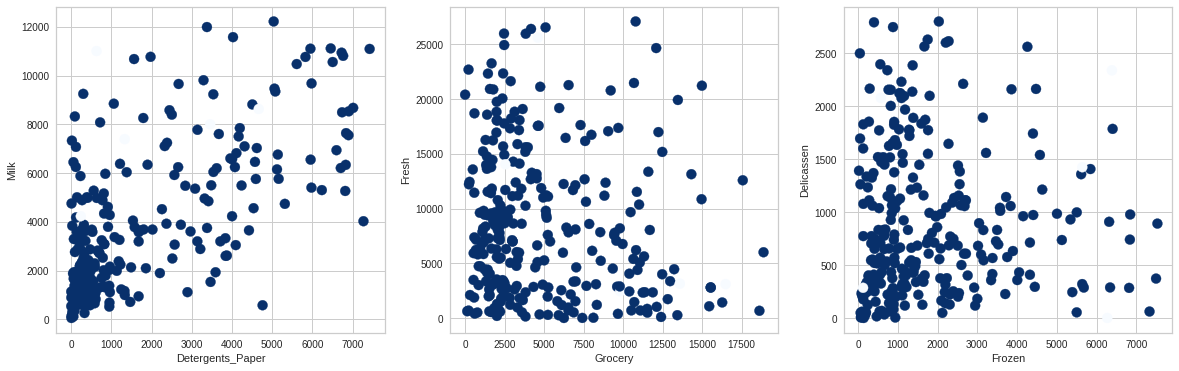

In [53]:
plt.figure(figsize=(20,6))
plt.subplots
plt.subplot(1,3,1)
plt.scatter(df_sin_outliers["Detergents_Paper"],df_sin_outliers["Milk"],s=100,c=df_sin_outliers["labels_DBSCAN_eps2"],cmap='Blues')
plt.xlabel("Detergents_Paper")
plt.ylabel("Milk")
plt.subplot(1,3,2)
plt.scatter(df_sin_outliers["Grocery"],df_sin_outliers["Fresh"],s=100,c=df_sin_outliers["labels_DBSCAN_eps2"],cmap='Blues')
plt.xlabel("Grocery")
plt.ylabel("Fresh")
plt.subplot(1,3,3)
plt.scatter(df_sin_outliers["Frozen"],df_sin_outliers["Delicassen"],s=100,c=df_sin_outliers["labels_DBSCAN_eps2"],cmap='Blues')
plt.xlabel("Frozen")
plt.ylabel("Delicassen")
plt.show()

In [54]:
clustering = DBSCAN(eps=1, min_samples=20)
clustering.fit(customers_scale)
df_sin_outliers['labels_DBSCAN_sam70'] = clustering.labels_
df_sin_outliers['labels_DBSCAN_sam70'].value_counts()

-1    191
 0     96
Name: labels_DBSCAN_sam70, dtype: int64

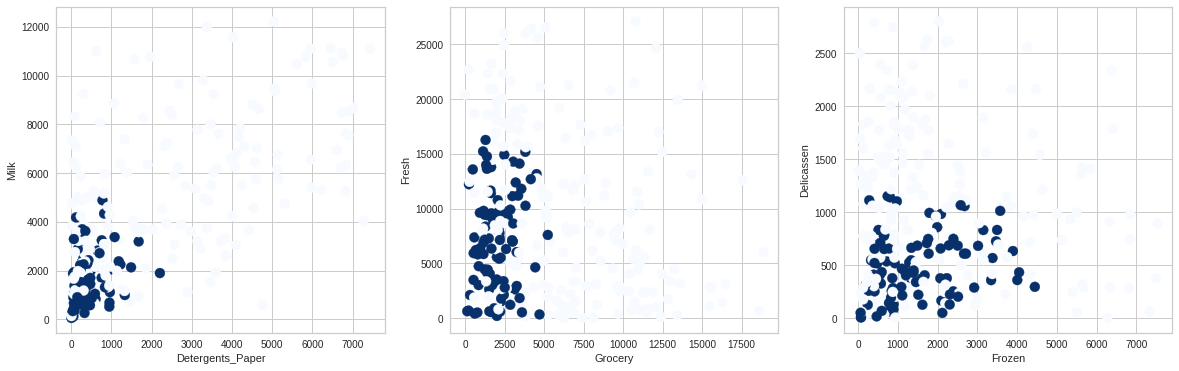

In [55]:
plt.figure(figsize=(20,6))
plt.subplots
plt.subplot(1,3,1)
plt.scatter(df_sin_outliers["Detergents_Paper"],df_sin_outliers["Milk"],s=100,c=df_sin_outliers["labels_DBSCAN_sam70"],cmap='Blues')
plt.xlabel("Detergents_Paper")
plt.ylabel("Milk")
plt.subplot(1,3,2)
plt.scatter(df_sin_outliers["Grocery"],df_sin_outliers["Fresh"],s=100,c=df_sin_outliers["labels_DBSCAN_sam70"],cmap='Blues')
plt.xlabel("Grocery")
plt.ylabel("Fresh")
plt.subplot(1,3,3)
plt.scatter(df_sin_outliers["Frozen"],df_sin_outliers["Delicassen"],s=100,c=df_sin_outliers["labels_DBSCAN_sam70"],cmap='Blues')
plt.xlabel("Frozen")
plt.ylabel("Delicassen")
plt.show()

Con el eps indicamos la distancia minima a la que queremos que se encuentren los puntos y con min_sample, el minimo de muestras que queremos que haya por cluster. Si no puede cumplir el minimo de muestras con la distancia impuesta, hace un unico cluster.